In [48]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, fixed, FloatSlider, IntSlider

In [79]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [80]:
def get_dados(indice='portfolio'):
    if indice=='portfolio':
        df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
        df.fillna(0, inplace=True)
    elif indice=='ACWI':    
        df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
        df.fillna(0, inplace=True)
        df['retorno'] = df['ACWI']
    else:
        url = f'https://query1.finance.yahoo.com/v7/finance/download/{indice}?period1=852076800&period2=1634743473&interval=1d&events=history&includeAdjustedClose=true'
        df = pd.read_csv(url)
        df['Date'] = pd.to_datetime(df['Date'])
        df['retorno'] = df['Close'].pct_change()
        
    df['year_week'] = df['Date'].dt.strftime('%Y-%U')
    df['retorno acumulado'] = df['retorno'] + 1
    df['retorno acumulado'] = df['retorno acumulado'].cumprod()
    
    df_gsrai = pd.read_csv('dados/GSRAII.csv', parse_dates=['Date']).sort_values('Date')

    df = df.merge(df_gsrai, on='Date')
    return df[['Date', 'retorno acumulado', 'GSRAII Index', 'year_week']].dropna()

### Indices:
- ^GSPC = *SP500*
- ^BVSP = *Bovespa*
- ACWI
- portfolio


* ver ouro, prata, petroleo, treasury

In [95]:
# Trocar codigo do indice
indice='IAU'
df = get_dados(indice=indice)
df

,Date,retorno acumulado,GSRAII Index,year_week
1,2005-01-31,0.990162,0.31,2005-05
2,2005-02-01,0.986648,0.36,2005-05
3,2005-02-02,0.989225,0.36,2005-05
4,2005-02-03,0.977278,0.45,2005-05
5,2005-02-04,0.972125,0.39,2005-05
...,...,...,...,...
4141,2021-08-19,3.971656,-0.11,2021-33
4142,2021-08-20,3.972827,-0.09,2021-33
4143,2021-08-23,4.020848,-0.02,2021-34
4144,2021-08-24,4.019677,0.08,2021-34


In [96]:
df['pct'] = df['retorno acumulado'].pct_change()
df['diff gsrai'] = (df['GSRAII Index']+5).pct_change()

In [97]:
df.corr()

,retorno acumulado,GSRAII Index,pct,diff gsrai
retorno acumulado,1.000000,-0.001511,0.060506,0.006717
GSRAII Index,-0.001511,1.000000,-0.000666,0.035569
pct,0.060506,-0.000666,1.000000,-0.031523
diff gsrai,0.006717,0.035569,-0.031523,1.000000


In [98]:
#%% Semanal
df_gp = df.groupby('year_week').agg('last')

In [99]:
# SHIFT +
# for pct in range(1,6):
#     df_gp[f'pct_{pct}_sem'] = (df_gp['retorno acumulado']/df_gp['retorno acumulado'].shift(pct).values -1) * 100

# SHIFT -
for pct in range(1,6):
    df_gp[f'pct_{pct}_sem'] = (df_gp['retorno acumulado'].shift(pct*-1).values/
                           df_gp['retorno acumulado'] -1) * 100

In [100]:
def classe_gsrai(df, limit=0, diff=None, media_movel=3):
    
    df=df.copy()
    df['gsrai_diff'] = df['GSRAII Index'].diff()
    
    if not media_movel == None: 
        df['mean'] = df['GSRAII Index'].rolling(media_movel).mean()
        up_down = df['mean']
        df['gsrai_gt_up'] = np.where((df['GSRAII Index'] > up_down) & (df['GSRAII Index'] >= limit), 1, 0)
        df['gsrai_gt_down'] = np.where((df['GSRAII Index'] < up_down) & (df['GSRAII Index'] >= limit), 1, 0)
        df['gsrai_lt_up'] = np.where((df['GSRAII Index'] > up_down) & (df['GSRAII Index'] < limit), 1, 0)
        df['gsrai_lt_down'] = np.where((df['GSRAII Index'] < up_down) & (df['GSRAII Index'] < limit), 1, 0)
    elif not diff == None: 
        df['gsrai_gt_up'] = np.where((df['gsrai_diff'] >= diff) & (df['GSRAII Index'] >= limit), 1, 0)
        df['gsrai_gt_down'] = np.where((df['gsrai_diff'] < diff) & (df['GSRAII Index'] >= limit), 1, 0)
        df['gsrai_lt_up'] = np.where((df['gsrai_diff'] >= diff) & (df['GSRAII Index'] < limit), 1, 0)
        df['gsrai_lt_down'] = np.where((df['gsrai_diff'] < diff) & (df['GSRAII Index'] < limit), 1, 0)
        
        
    regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']
    df['classe'] = np.nan
    for col in regras:
        df.loc[df[col]==1, 'classe'] = col
    return df

In [101]:
df_gp =  classe_gsrai(df=df_gp, limit=0, media_movel=None, diff=0)
# df_gp['classe'] = df_gp['classe'].shift(-1).values
for col in ['pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem', 'pct_5_sem']:
    df_gp[col] = df_gp[col].shift(1).values


In [102]:
df_gp

,Date,retorno acumulado,GSRAII Index,pct,diff gsrai,pct_1_sem,pct_2_sem,pct_3_sem,pct_4_sem,pct_5_sem,gsrai_diff,gsrai_gt_up,gsrai_gt_down,gsrai_lt_up,gsrai_lt_down,classe
year_week,,,,,,,,,,,,,,,,
2005-05,2005-02-04,0.972125,0.39,-0.005273,-0.011009,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,NaN
2005-06,2005-02-11,0.986648,0.46,0.007414,0.000000,1.493976,3.228916,4.915663,4.650602,7.228916,0.07,1,0,0,0,gsrai_gt_up
2005-07,2005-02-18,1.003514,0.56,0.002340,0.007246,1.709402,3.371320,3.110161,5.650522,4.344729,0.10,1,0,0,0,gsrai_gt_up
2005-08,2005-02-25,1.019911,0.59,0.002533,0.003591,1.633987,1.377218,3.874883,2.591036,-0.863679,0.03,1,0,0,0,gsrai_gt_up
2005-09,2005-03-04,1.017334,0.70,0.008593,0.000000,-0.252641,2.204869,0.941663,-2.457510,-2.090032,0.11,1,0,0,0,gsrai_gt_up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-30,2021-07-30,4.047786,0.11,-0.007752,-0.013514,0.787402,-2.245555,-1.224853,-1.079041,-0.583263,-0.20,0,1,0,0,gsrai_gt_down
2021-31,2021-08-06,3.925978,0.31,-0.024163,0.013359,-3.009262,-1.996534,-1.851860,-1.359957,NaN,0.20,1,0,0,0,gsrai_gt_up
2021-32,2021-08-13,3.966971,0.26,0.014376,-0.016822,1.044150,1.193311,1.700477,NaN,NaN,-0.05,0,1,0,0,gsrai_gt_down


In [103]:
pct =  'pct_1_sem'
regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']

In [104]:
lista = []
for col in df_gp['classe'].dropna().unique():
    desc = df_gp[df_gp[col]==1][[pct]].describe().rename(columns={pct: col})
    lista.append(desc)
pd.concat(lista, axis=1)

,gsrai_gt_up,gsrai_gt_down,gsrai_lt_down,gsrai_lt_up
count,250.000000,186.000000,213.000000,222.000000
mean,0.033424,0.428481,0.424959,-0.051730
std,2.228318,1.861506,3.014529,2.409320
min,-6.883790,-6.196581,-9.132153,-9.056984
25%,-1.423979,-0.707272,-1.095890,-1.313004
50%,0.235020,0.440878,0.640282,0.000000
75%,1.425554,1.693648,2.083324,1.347733
max,6.099196,5.054764,14.130729,8.573440


In [105]:
@interact(df=fixed(df_gp), 
          pct=['pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem', 'pct_5_sem'],
          limit=FloatSlider(min=-1, max=1, step=0.05, value=0),
          diff=FloatSlider(min=-1, max=1, step=0.05, value=0),
#           media_movel=IntSlider(min=2, max=6, step=1, value=3)
         )
def hist_classes(df, pct, limit=0, diff=0):
    df = classe_gsrai(df=df, limit=limit, media_movel=None, diff=diff).dropna()
    fig = px.histogram(df.sort_values('classe'), x=pct, color="classe", marginal="box", nbins=100, 
#                        range_y=[0,50],
                       range_x=[df[pct].min()-1,df[pct].max()+1],
                       title=f'Distribuição {indice} {pct} ',
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.65)
    fig.add_vline(x=0,line_dash="dash")
    
    for i, classe in enumerate(df['classe'].unique()):
        fig.add_annotation(text=f'Total {classe}: {len(df[df["classe"]==classe])}',
                           showarrow=False, yshift=70-(i*19), xshift=450)
        fig.add_annotation(text=f'σ {classe}: {df[df["classe"]==classe][pct].std():.2f} ',
                       showarrow=False, yshift=200-(i*19), xshift=450)   
    return fig

    
hist_classes(df_gp, pct, limit=-1, diff=0);

interactive(children=(Dropdown(description='pct', options=('pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem',…

In [106]:
@interact(df=fixed(df_gp), 
          pct=['pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem', 'pct_5_sem'],
          limit=FloatSlider(min=-1, max=1, step=0.05, value=0),
#           media_movel=IntSlider(min=2, max=6, step=1, value=3)
         )
def hist_diff(df, pct, limit=0):
    df = classe_gsrai(df=df, limit=limit, media_movel=3).dropna()
    df = df.copy()
    df['classe_diff'] = np.where(df['gsrai_diff']<=limit, 'abaixo', 'acima')
    fig = px.histogram(df.sort_values('classe_diff', ascending=False), 
                       x=pct, color="classe_diff", 
                       marginal="box", nbins=100, 
#                        range_y=[0,50],
                       range_x=[df[pct].min()-1,df[pct].max()+1],
                       title=f'Distribuição {indice} {pct} por diff GSRAI',
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.65)
    fig.add_vline(x=0,line_dash="dash")
    
    for i, classe in enumerate(df['classe_diff'].unique()):
        fig.add_annotation(text=f'Total {classe}: {len(df[df["classe_diff"]==classe])}',
                           showarrow=False, yshift=100-(i*19), xshift=450)
        fig.add_annotation(text=f'σ {classe}: {df[df["classe_diff"]==classe][pct].std():.2f} ',
                       showarrow=False, yshift=200-(i*19), xshift=450)   
    return fig

    
hist_diff(df_gp, pct);

interactive(children=(Dropdown(description='pct', options=('pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem',…

In [14]:
cut = df_gp[pct].quantile(0.15)
df_gp[(df_gp[pct]<=cut)].sum()

retorno acumulado                                           330.496237
GSRAII Index                                                    -72.67
pct_1_sem                                                  -616.750175
pct_2_sem                                                  -632.461834
pct_3_sem                                                  -620.797128
pct_4_sem                                                  -635.701109
pct_5_sem                                                  -648.560129
gsrai_diff                                                      -31.37
gsrai_gt_up                                                         33
gsrai_gt_down                                                       43
gsrai_lt_up                                                         28
gsrai_lt_down                                                       92
classe               gsrai_gt_downgsrai_lt_downgsrai_lt_downgsrai_l...
dtype: object

In [64]:
@interact(df=fixed(df_gp), 
          pct=['pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem', 'pct_5_sem'],
          limit=FloatSlider(min=-1, max=1, step=0.05, value=0),
#           diff=FloatSlider(min=-1, max=1, step=0.05, value=0),
          media_movel=IntSlider(min=2, max=6, step=1, value=3)
         )
def hist_classes(df, pct, limit=0, media_movel=3):
    df = classe_gsrai(df=df, limit=limit, media_movel=3, diff=None).dropna()
    fig = px.histogram(df.sort_values('classe'), x=pct, color="classe", marginal="box", nbins=100, 
#                        range_y=[0,50],
                       range_x=[df[pct].min()-1,df[pct].max()+1],
                       title=f'Distribuição {indice} {pct} ',
                      )
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.65)
    fig.add_vline(x=0,line_dash="dash")
    
    for i, classe in enumerate(df['classe'].unique()):
        fig.add_annotation(text=f'Total {classe}: {len(df[df["classe"]==classe])}',
                           showarrow=False, yshift=70-(i*19), xshift=450)
        fig.add_annotation(text=f'σ {classe}: {df[df["classe"]==classe][pct].std():.2f} ',
                       showarrow=False, yshift=200-(i*19), xshift=450)   
    return fig

    
hist_classes(df_gp, pct, limit=-1, diff=0);

interactive(children=(Dropdown(description='pct', options=('pct_1_sem', 'pct_2_sem', 'pct_3_sem', 'pct_4_sem',…

TypeError: hist_classes() got an unexpected keyword argument 'diff'

In [16]:
df_gp[(df_gp[pct]>cut) & (df_gp['gsrai_lt_down']==0)][pct].describe()

count    866.000000
mean       0.778018
std        1.545590
min       -1.653355
25%       -0.296404
50%        0.565290
75%        1.575856
max       12.876584
Name: pct_1_sem, dtype: float64

In [17]:
df_gp.columns

Index(['Date', 'retorno acumulado', 'GSRAII Index', 'pct_1_sem', 'pct_2_sem',
       'pct_3_sem', 'pct_4_sem', 'pct_5_sem', 'gsrai_diff', 'gsrai_gt_up',
       'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down', 'classe'],
      dtype='object')

In [18]:
# import seaborn as sns
# sns.pairplot(df_gp.drop(columns= ['gsrai_gt_up',
#        'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']), hue='classe');

In [19]:
df_gp.to_csv('gsrai.csv')

In [20]:
df_gp['2019-35':'2019-45']

,Date,retorno acumulado,GSRAII Index,pct_1_sem,pct_2_sem,pct_3_sem,pct_4_sem,pct_5_sem,gsrai_diff,gsrai_gt_up,gsrai_gt_down,gsrai_lt_up,gsrai_lt_down,classe
year_week,,,,,,,,,,,,,,
2019-35,2019-09-06,2.160403,-0.56,1.025457,3.153910,2.719429,3.906839,4.964992,0.38,0,0,1,0,gsrai_lt_up
2019-36,2019-09-13,2.093113,-0.10,-3.114659,-2.121142,-0.058983,-0.479931,0.670495,0.46,0,0,1,0,gsrai_lt_up
2019-37,2019-09-20,2.135830,-0.25,2.040805,-1.137419,-0.123625,1.980618,1.551079,-0.15,0,0,0,1,gsrai_lt_down
2019-38,2019-09-27,2.121000,-0.51,-0.694308,1.332327,-1.823830,-0.817075,1.272558,-0.26,0,0,0,1,gsrai_lt_down
2019-39,2019-10-04,2.150420,-0.75,1.387055,0.683117,2.737863,-0.462072,0.558647,-0.24,0,0,0,1,gsrai_lt_down
2019-40,2019-10-11,2.111412,-0.30,-1.813965,-0.452070,-1.143240,0.874234,-2.267655,0.45,0,0,1,0,gsrai_lt_up
2019-41,2019-10-18,2.119937,-0.16,0.403740,-1.417548,-0.050155,-0.744115,1.281504,0.14,0,0,1,0,gsrai_lt_up
2019-42,2019-10-25,2.137325,0.05,0.820231,1.227283,-0.608944,0.769665,0.070013,0.21,1,0,0,0,gsrai_gt_up
2019-43,2019-11-01,2.182062,0.05,2.093110,2.930509,3.346081,1.471419,2.878884,0.00,1,0,0,0,gsrai_gt_up


In [21]:
df_gp[(df_gp['pct_ret']<0) & (df_gp['gsrai_lt_down']==1)]['pct_ret'].describe()

KeyError: 'pct_ret'

In [22]:
df_gp[(df_gp['gsrai_lt_down']==1)]['pct_ret'].describe()

KeyError: 'pct_ret'

In [ ]:
df_gp[(df_gp['gsrai_lt_down']==1)]['pct_ret_shift'].describe()

In [ ]:
df['retorno acumulado'].plot()

In [ ]:
#%% Grafico

fig = px.line(df, x="Date", y='retorno acumulado')
# mask = df_gp['gsrai_lt_down']==1
# fig = px.line(df_gp, x="Date", y=['GSRAII Index', 'pct_ret'])

# fig.add_trace(go.Scatter(
#     x=df_gp[mask]['Date'],
#     y=df_gp[mask][pct],
#     marker_size=10, mode='markers', name='Queda',
#     ))

fig.show()

In [ ]:
df_gp

In [76]:
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf

lag_acf = acf(df['GSRAII Index'].dropna(), nlags=30)
lag_pacf = pacf(df['GSRAII Index'].dropna(), nlags=30)

C:\ProgramData\Anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning:

fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.



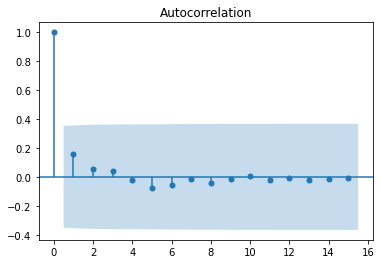

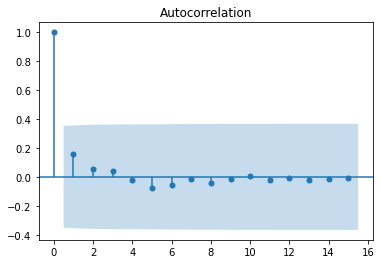

In [77]:
plot_acf(lag_acf)

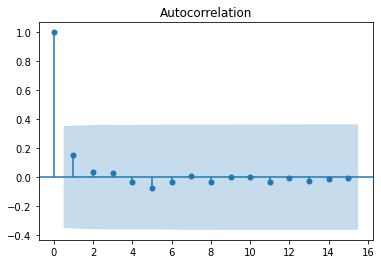

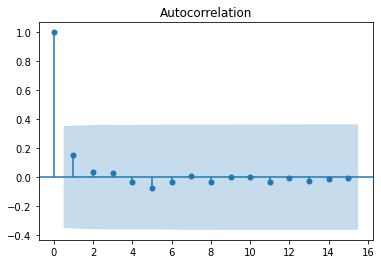

In [78]:
plot_acf(lag_pacf)

In [26]:
adfuller(df_gp['gsrai_diff'].dropna())

(-22.671880253074363,
 0.0,
 2,
 1298,
 {'1%': -3.4353979810093374,
  '5%': -2.863769264797245,
  '10%': -2.5679568752685773},
 172.3854123349738)

In [29]:
df_gp['pct_1_sem'].describe()

count    1301.000000
mean        0.098809
std         2.155702
min       -19.463629
25%        -0.948630
50%         0.156765
75%         1.329289
max        12.876584
Name: pct_1_sem, dtype: float64

In [32]:
df_gp[df_gp['gsrai_diff']<-0.3]['pct_1_sem'].describe()

count    124.000000
mean      -1.674951
std        3.252771
min      -19.463629
25%       -2.723671
50%       -1.062060
75%       -0.064888
max        8.568106
Name: pct_1_sem, dtype: float64

<AxesSubplot:xlabel='year_week'>

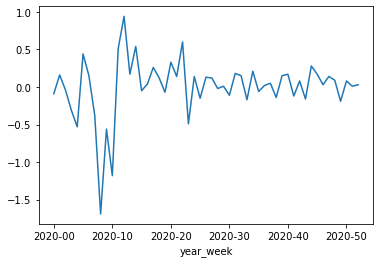

In [28]:
df_gp['2019:01':'2020:20']['gsrai_diff'].plot()

In [33]:
df

,Date,retorno acumulado,GSRAII Index,year_week
0,1997-01-02,1.000000,-0.04,1997-00
1,1997-01-03,1.004739,0.13,1997-00
2,1997-01-06,1.013472,0.22,1997-01
3,1997-01-07,1.013524,0.21,1997-01
4,1997-01-08,1.012990,0.22,1997-01
...,...,...,...,...
6385,2021-08-19,2.640252,-0.11,2021-33
6386,2021-08-20,2.627207,-0.09,2021-33
6387,2021-08-23,2.677371,-0.02,2021-34
6388,2021-08-24,2.686924,0.08,2021-34
